# Clustering Models

Clustering is a foundational data analysis task, where members of the data set are sorted into groups or "clusters" according to measured similarities between the objects. According to some quantitative criteria, members of the same cluster are similar and members of distinct clusters are different.

In [1]:
import numpy as np
import pandas as pd
import graspy
import matplotlib.pyplot as plt
%matplotlib inline

## Automatic Gaussian Mixture Model (AUTOGMM)

The Automatic Gaussian Mixture Model or AutoGMM is a clustering algorithm that uses Sklearn's hierarchical agglomerative clustering and then Gaussian mixtured model (GMM) fitting. Different combinations of agglomeration, GMM,and cluster numbers are used in the algorithm, and the clustering with the best selection criterion (bic/aic) is chosen.

Clustering is a foundational data analysis task, where members of the data set are sorted into groups or "clusters" according to measured similarities between the objects. According to some quantitative criteria, members of the same cluster are similar and members of distinct clusters are different. 

This algorithm is a Gaussian mixture model (GMM), a statistical model of clustered data that, simply put, is a composition of multiple normal distributions. Each cluster has a weight $w_k$ assigned to it, and the combined probability distribution, $f(x)$, is of the form:

$f(x) = \sum\limits_{k = 1}^K {w_{k}f_{k}(x)} = \sum\limits_{k = 1}^K {\frac{w_{k}}{(2\pi)^{\frac{d}{2}}|\sum_{k}|^{-\frac{1}{2}}}e^{[\frac{1}{2}(x - \mu_{k})^{T}\sum_{k}^{-1}(x - \mu_{k})]}}$

where $k$ is the total number of clusters and $d$ is the dimensionality of the data.

Expectation Maximization (EM) algorithms are then run to estimate model parameters and the fitted GMM is used to cluster the data.

Let's look at an example with carefully created synthetic data from this [paper](https://arxiv.org/abs/1909.02688)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:   17.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:   15.8s finished
Run 1 Results
Info:
Best model: ['euclidean', 'ward', 'spherical']
Best reg: 0.0
Best k: 3
Best BIC: -1120.483921563501
Best ari: 1.0

Run 2 Results
Info:
Best model: ['cosine', 'complete', 'full']
Best reg: 1e-06
Best k: 10
Best BIC: -1025.262289842934
Best ari: 0.5091209398938044

Paper Reproduction Results
Info:
Best model: ['euclidean', 'ward', 'spherical']
Best reg: 0.0
Best k: 3
Best BIC: -1120.483921563501
Best ari: 1.0
/home/cpw/.conda/envs/graspy/lib/python3.7/site-packages/ipykernel_launcher.py:93: UserWarning: FixedFormat

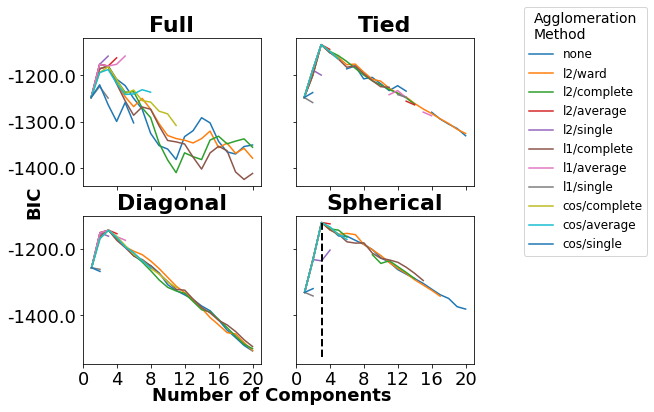

In [7]:
import csv
import time
import random

from sklearn.datasets import load_iris
from sklearn import datasets
import matplotlib.colors as colors

from graspy.cluster.autogmm import AutoGMMCluster
from graspy.simulations import sbm
from graspy.plot import heatmap

np.random.seed(10)


# Using all forms of clustering
ks = [i for i in range(1,21)]
affinities = 'all'
linkages = 'all'
covariance_types='all'
    
# Creating Synthetic Data
x = np.genfromtxt('/home/cpw/data/synthetic.csv', delimiter=',',skip_header=0)
x = x[:,np.arange(1,x.shape[1])]
c_true = np.genfromtxt('/home/cpw/data/synthetic.csv', delimiter=',', usecols = (0),skip_header=0)

def make_bic_plots(results,best_cov,best_k_bic,best_bic):
    #plot of all BICS*******************************
    titles = ['Full','Tied','Diagonal','Spherical']
    bics = np.zeros((44,20))
    cov_types = ['full','tied','diag','spherical']
    for i,cov_type in enumerate(cov_types):
        bics[i*11+0,:] = -results.loc[(results['covariance_type'] == cov_type) &
            (results['affinity'] == 'none')]['bic/aic'].values
        bics[i*11+1,:] = -results.loc[(results['covariance_type'] == cov_type) &
            (results['affinity'] == 'euclidean') & (results['linkage'] == 'ward')]['bic/aic'].values
        bics[i*11+2,:] = -results.loc[(results['covariance_type'] == cov_type) &
            (results['affinity'] == 'euclidean') & (results['linkage'] == 'complete')]['bic/aic'].values
        bics[i*11+3,:] = -results.loc[(results['covariance_type'] == cov_type) &
            (results['affinity'] == 'euclidean') & (results['linkage'] == 'average')]['bic/aic'].values
        bics[i*11+4,:] = -results.loc[(results['covariance_type'] == cov_type) &
            (results['affinity'] == 'euclidean') & (results['linkage'] == 'single')]['bic/aic'].values
        bics[i*11+5,:] = -results.loc[(results['covariance_type'] == cov_type) &
            (results['affinity'] == 'manhattan') & (results['linkage'] == 'complete')]['bic/aic'].values
        bics[i*11+6,:] = -results.loc[(results['covariance_type'] == cov_type) &
            (results['affinity'] == 'manhattan') & (results['linkage'] == 'average')]['bic/aic'].values
        bics[i*11+7,:] = -results.loc[(results['covariance_type'] == cov_type) &
            (results['affinity'] == 'manhattan') & (results['linkage'] == 'single')]['bic/aic'].values
        bics[i*11+8,:] = -results.loc[(results['covariance_type'] == cov_type) &
            (results['affinity'] == 'cosine') & (results['linkage'] == 'complete')]['bic/aic'].values
        bics[i*11+9,:] = -results.loc[(results['covariance_type'] == cov_type) &
            (results['affinity'] == 'cosine') & (results['linkage'] == 'average')]['bic/aic'].values
        bics[i*11+10,:] = -results.loc[(results['covariance_type'] == cov_type) &
            (results['affinity'] == 'cosine') & (results['linkage'] == 'single')]['bic/aic'].values


    labels = {0:'none',1:'l2/ward',2:'l2/complete',3:'l2/average',4:'l2/single',
            5:'l1/complete',6:'l1/average',7:'l1/single',8:'cos/complete',
            9:'cos/average',10:'cos/single'}
        
    fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(2,2,sharey='row',sharex='col',figsize=(7,6))
    for row in np.arange(bics.shape[0]):
        if all(bics[row,:]==-np.inf):
            continue
        if row<=10:
            ax0.plot(np.arange(1,len(ks)+1),bics[row,:])
        elif row<=21:
            ax1.plot(np.arange(1,len(ks)+1),bics[row,:],label=labels[row%11])
        elif row<=32:
            ax2.plot(np.arange(1,len(ks)+1),bics[row,:])
        elif row<=43:
            ax3.plot(np.arange(1,len(ks)+1),bics[row,:])
    
    #plot line indicating chosen model
    if best_cov == 'full':
        ylims = ax0.get_ylim()
        ax0.plot([best_k_bic,best_k_bic],[ylims[0],best_bic],color='black',linestyle='dashed',linewidth=2)
    elif best_cov == 'tied':
        ylims = ax1.get_ylim()
        ax1.plot([best_k_bic,best_k_bic],[ylims[0],best_bic],color='black',linestyle='dashed',linewidth=2)
    elif best_cov == 'diag':
        ylims = ax2.get_ylim()
        ax2.plot([best_k_bic,best_k_bic],[ylims[0],best_bic],color='black',linestyle='dashed',linewidth=2)
    elif best_cov == 'spherical':
        ylims = ax3.get_ylim()
        ax3.plot([best_k_bic,best_k_bic],[ylims[0],best_bic],color='black',linestyle='dashed',linewidth=2)
    
    fig.text(0.5, 0.04, 'Number of Components', ha='center',fontsize=18,fontweight='bold')
    fig.text(0.01, 0.5, 'BIC', va='center', rotation='vertical',fontsize=18,fontweight='bold')
    
    ax0.set_title(titles[0],fontsize=22,fontweight='bold')
    ax0.locator_params(axis='y',tight=True,nbins=4)
    ax0.set_yticklabels(ax0.get_yticks(),fontsize=18)

    ax1.set_title(titles[1],fontsize=22,fontweight='bold')
    legend = ax1.legend(loc='best',bbox_to_anchor=(1.25, 1.25, 0, 0),title='Agglomeration\nMethod',fontsize=12)
    plt.setp(legend.get_title(),fontsize=14)

    ax2.set_title(titles[2],fontsize=22,fontweight='bold')
    ax2.set_xticks(range(0,21,4))
    ax2.set_xticklabels(ax2.get_xticks(),fontsize=18)
    ax2.locator_params(axis='y',tight=True,nbins=4)
    ax2.set_yticklabels(ax2.get_yticks(),fontsize=18)
    

    ax3.set_title(titles[3],fontsize=22,fontweight='bold')
    ax3.set_xticks(range(0,21,4))
    ax3.set_xticklabels(ax3.get_xticks(),fontsize=18)

# Run algorithm
run_1 = AutoGMMCluster(affinity='all',linkage='all',covariance_type='all',
    random_state=None, label_init=None, selection_criteria="bic", verbose=2, max_agglom_size=2000, n_jobs=None)

run_2 = AutoGMMCluster(affinity='all',linkage='all',covariance_type='all',
    random_state=None, label_init=None, selection_criteria="aic", verbose=2, max_agglom_size=2000, n_jobs=None)

pyc = AutoGMMCluster(min_components=ks[0],max_components=ks[len(ks)-1],
    affinity=affinities,linkage=linkages,covariance_type=covariance_types,
    random_state=0)

run_1.fit(x,c_true)

run_2.fit(x,c_true)

pyc.fit(x,c_true)

# Calculated covariates
print("Run 1 Results")
print("=============")

combo = [run_1.affinity_,run_1.linkage_,run_1.covariance_type_]
k = run_1.n_components_
reg = run_1.reg_covar_
bic = -run_1.criter_
results = run_1.results_
ari = run_1.ari_
c_hat_autogmm = run_1.predictions

print('Info:')
print('Best model: ' + str(combo))
print('Best reg: ' + str(reg))
print('Best k: ' + str(k))
print('Best BIC: ' + str(bic))
print('Best ari: ' + str(ari))


print("\nRun 2 Results")
print("=============")

combo = [run_2.affinity_,run_2.linkage_,run_2.covariance_type_]
k = run_2.n_components_
reg = run_2.reg_covar_
bic = -run_2.criter_
results = run_2.results_
ari = run_2.ari_
c_hat_autogmm = run_2.predictions

print('Info:')
print('Best model: ' + str(combo))
print('Best reg: ' + str(reg))
print('Best k: ' + str(k))
print('Best BIC: ' + str(bic))
print('Best ari: ' + str(ari))


print("\nPaper Reproduction Results")
print("==========================")

combo = [pyc.affinity_,pyc.linkage_,pyc.covariance_type_]
k = pyc.n_components_
reg = pyc.reg_covar_
bic = -pyc.criter_
results = pyc.results_
ari = pyc.ari_
c_hat_autogmm = pyc.predictions

print('Info:')
print('Best model: ' + str(combo))
print('Best reg: ' + str(reg))
print('Best k: ' + str(k))
print('Best BIC: ' + str(bic))
print('Best ari: ' + str(ari))

# BIC Plots
make_bic_plots(results,combo[2],k,bic)


In [8]:
# The results and all calculations are presented as a dataframe
print(pyc.results_)

                                                 model      bic/aic       ari  \
0    GaussianMixture(covariance_type='spherical',\n...  1330.759121  0.000000   
1    GaussianMixture(covariance_type='spherical',\n...  1229.575046  0.603087   
2    GaussianMixture(covariance_type='spherical',\n...  1120.483922  1.000000   
3    GaussianMixture(covariance_type='spherical',\n...  1142.478626  0.808816   
4    GaussianMixture(covariance_type='spherical',\n...  1156.032480  0.707115   
..                                                 ...          ...       ...   
875   GaussianMixture(n_components=16, random_state=0)  1342.811799  0.272436   
876   GaussianMixture(n_components=17, random_state=0)  1365.514390  0.254864   
877   GaussianMixture(n_components=18, random_state=0)  1370.061491  0.239264   
878   GaussianMixture(n_components=19, random_state=0)  1353.817180  0.237126   
879   GaussianMixture(n_components=20, random_state=0)  1350.562516  0.220660   

     n_components   affinit

## K-Means Clustering (kclust)

kclust is a clustering algorithm that finds the optimal model by using all algorithms and calculating the lowest silhouette score from Sklearn.

Here is the same simple example.

In [5]:
from graspy.cluster.kclust import KMeansCluster

# Ex
x = np.identity(10)
KMeansClust = KMeansCluster(max_clusters=5)
KMeansClust.fit(x)

KMeansClust.model_

KMeans(n_clusters=4)

Here is the same complex example.

In [ ]:
# Creating Synthetic Data
x = np.genfromtxt('/home/caseypw/data/synthetic.csv', delimiter=',',skip_header=0)
x = x[:,np.arange(1,x.shape[1])]
c_true = np.genfromtxt('/home/caseypw/data/synthetic.csv', delimiter=',', usecols = (0),skip_header=0)

KMeansClust.fit(x, c_true)

KMeansClust.model_

## GraspyClust (gclust)

gclust is the last clustering algorithm and it is purely a GMM approach, with no agglomerative clustering.

Last simple example.

In [ ]:
from graspy.cluster.gclust import GaussianCluster

# Ex
x = np.identity(10)
GClust = GaussianCluster()
GClust.fit(x)

GClust.model_

Complex example.

In [ ]:
# Creating Synthetic Data
x = np.genfromtxt('/home/caseypw/data/synthetic.csv', delimiter=',',skip_header=0)
x = x[:,np.arange(1,x.shape[1])]
c_true = np.genfromtxt('/home/caseypw/data/synthetic.csv', delimiter=',', usecols = (0),skip_header=0)

GClust.fit(x, c_true)

GClust.model_